# 3D analysis of GRB 190829A: A low level interface
### Introduction:

- Understanding the gammapy data workflow is the first step, in particular what are DL3 events and intrument response functions (IRF).

- Understanding of how the data reduction and modeling fitting process is done.

- In this notebook, we used an introduction to gammapy analysis notebook provided in the gammapy website [here](https://docs.gammapy.org/0.17/notebooks/analysis_2.html).
- We used the lower level classes and functions the library. This allows to understand what happens during two main gammapy analysis steps, data reduction and modeling/fitting.

### Objective: 
- Create a 3D dataset of the GRB using the H.E.S.S. DL3 data observed in the first night of the burst and perform a simple model fitting of the Crab nebula using the lower level gammapy API.
### Methods:
- we have to interact with the data archive (with the gammapy.data.DataStore) to retrieve a list of selected observations (gammapy.data.Observations). 
- Then, we define the geometry of the gammapy.datasets.MapDataset object we want to produce and the maker object that reduce an observation to a dataset.
- We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

- In practice, we have to: 
    - Create a gammapy.data.DataStore poiting to the relevant data 
    - Apply an observation selection to produce a list of observations, a gammapy.data.Observations object. 
    - Define a geometry of the Map we want to produce, with a sky projection and an energy range. 
    - Create a gammapy.maps.MapAxis for the energy 
    - Create a gammapy.maps.WcsGeom for the geometry 
    - Create the necessary makers : 
        - The map dataset maker : gammapy.makers.MapDatasetMaker. 
        - The background normalization maker, here a gammapy.makers.FoVBackgroundMaker. 
        - And usually the safe range maker : gammapy.makers.SafeRangeMaker 
        - Perform the data reduction loop. 
    - And for every observation: 
        - Apply the makers sequentially to produce the current gammapy.datasets.MapDataset 
        - Stack it on the target one. - Define the gammapy.modeling.models.SkyModel to apply to the dataset. 
        - Create a gammapy.modeling.Fit object and run it to fit the model parameters 
        - Apply a gammapy.estimators.FluxPointsEstimator to compute flux points for the spectral part of the fit.

### Setup:
- First, we setup the analysis by performing required imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import numpy as np

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset,Datasets, FluxPointsDataset
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import ExcessMapEstimator

In [4]:
import warnings
warnings.filterwarnings('ignore')

## plot formatting and saving

In [5]:
W = 14
params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
         'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'),
          'font.family': 'lmodern',
          'legend.fontsize': 16,
          
          }

plt.rcParams.update(params)


run_list = 'night1'
bkgmodel_version = "v07c"


work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/"
def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf']
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_3D/{}/jupyter_notebooks/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))

## Defining the datastore and selecting observations

- gammapy.data.DataStore object is used to access the observations to be analyse. 
- we use std impact fits datasets of HESS DL3

In [6]:
position = SkyCoord(44.544, -8.958, unit='deg', frame='icrs') # or SkyCoord.from_name("GRB")


In [7]:
def get_runlist(run_list):
    cluster1 = [152900, 152901]
    cluster2 = [152902, 152903, 152904]
    cluster3 = [152905, 152906, 152907]

    runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
    runs_hybrid = [152900, 152901, 152902, 152903, 152904, 152905]
    runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
    runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)


    options = ["night1","night2","night3","all","cluster1","cluster2","cluster3"]

    if run_list not in options:
        print("Invalid option,use\n")
        print(options)
        return []

    else:
        if run_list == 'night1':
            runs = runs_night1
        elif run_list == 'night2':
            runs = runs_night2
        elif run_list == 'night3':
            runs = runs_night3
        elif run_list == 'all':
            runs = runs_night1 + runs_night2 + runs_night3
        elif run_list == "cluster1":
            runs = cluster1
        elif run_list == "cluster2":
            runs = cluster2
        elif run_list == "cluster3":
            runs = cluster3
        elif run_list == "hybrid":
            runs = runs_hybrid
        return runs

def load_data(runs):
    # Load FITS data from H.E.S.S database/local cpu
    ds = DataStore.from_dir("$GAMMAPY_DATA/std_ImPACT_fullEnclosure")
    observations = ds.get_observations(runs)

    return observations, ds


In [8]:
name_file = '3D_Bkg_night1_joint_jupyter'
print(name_file)
run_list = 'night1'
# we load the data here:
runs = get_runlist(run_list)

observations, datastore = load_data(runs)


3D_Bkg_night1_joint_jupyter


In [9]:
energy_axis = MapAxis.from_energy_bounds(0.1, 10,16, unit="TeV", per_decade=True)
#energy_axis = MapAxis.from_energy_bounds(0.1, 100.0, 48, unit="TeV")
geom = WcsGeom.create(
    skydir=position,
    binsz=0.02,
    width=(5, 5),
    frame="icrs",
    proj="TAN",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 20, 20, unit="TeV", name="energy_true", per_decade=True
)
#print(energy_axis)

In [10]:
circle = CircleSkyRegion(
    center=position, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = Map.from_geom(geom=geom, data=data)
maker_fov = FoVBackgroundMaker(exclusion_mask=exclusion_mask)

In [11]:
%%time
offset_max = 3.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max",'edisp-bias'], offset_max=offset_max, bias_percent=10)

#maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)
stacked = MapDataset.create(geom)
datasets =  []

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.norm.value:.2f}"
    )
    datasets.append(dataset)
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 152900: 0.89
Background norm obs 152901: 0.96
Background norm obs 152902: 0.82
Background norm obs 152903: 0.74
Background norm obs 152904: 0.85
Background norm obs 152905: 0.86
Background norm obs 152906: 0.80
Background norm obs 152907: 0.90
CPU times: user 22.4 s, sys: 5.47 s, total: 27.9 s
Wall time: 28 s


In [12]:
print(stacked)

MapDataset
----------

  Name                            : fbBanZoR 

  Total counts                    : 22740 
  Total predicted counts          : 22423.38
  Total background counts         : 22423.38

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 3.81e+09 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1750000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 205580.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : fbBanZoR-bkg
    Datasets names            : ['fbBanZoR']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


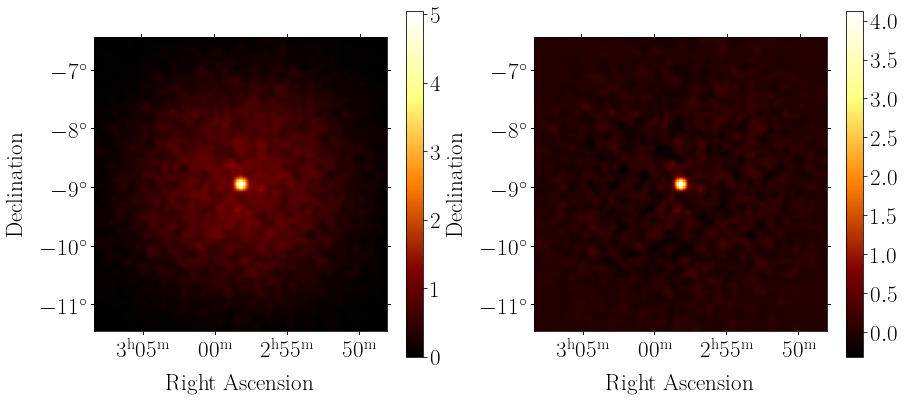

In [13]:
fig = plt.figure(figsize=(14,6))
ax1=plt.subplot(121, projection=stacked.counts.geom.wcs)
count = stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(ax=ax1,  add_cbar=True)
ax2=plt.subplot(122, projection=stacked.counts.geom.wcs)
sm = stacked.residuals().sum_over_axes().smooth(0.05 * u.deg).plot(ax=ax2, add_cbar=True);
save(fig, 'counts_residual_3d_low_level')

In [14]:
path = Path("../Data/3D_low_level_dataset")
path.mkdir(exist_ok=True)

In [15]:
filename = path / "grb190829a-std_impact_stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

In [16]:
for obs, dataset in zip(observations.ids, datasets):
    filename = path / f"grb190829a-3d_joint_{obs}_dataset.fits.gz"
    dataset.write(filename, overwrite=True)

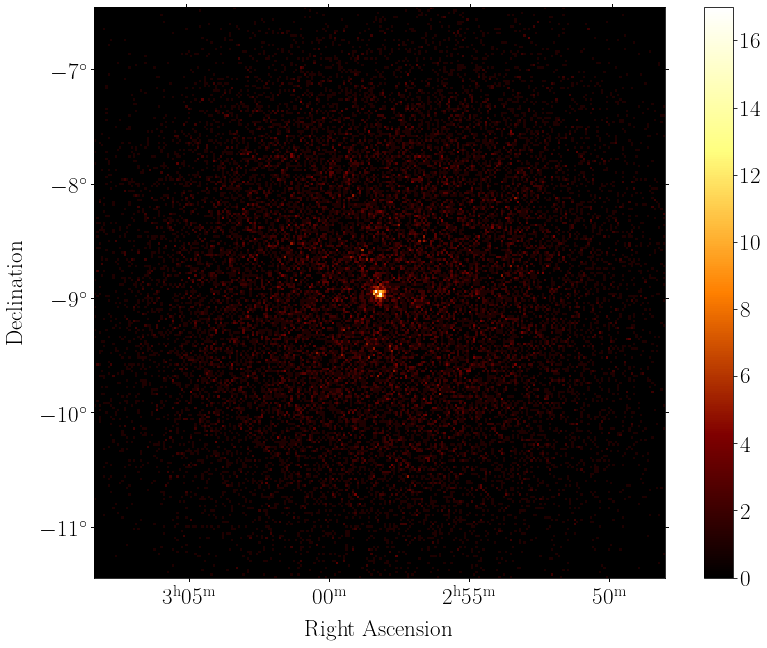

In [17]:
count_map = stacked.counts.sum_over_axes().plot(add_cbar=True);
save(fig, '3d_counts_map_low_level')

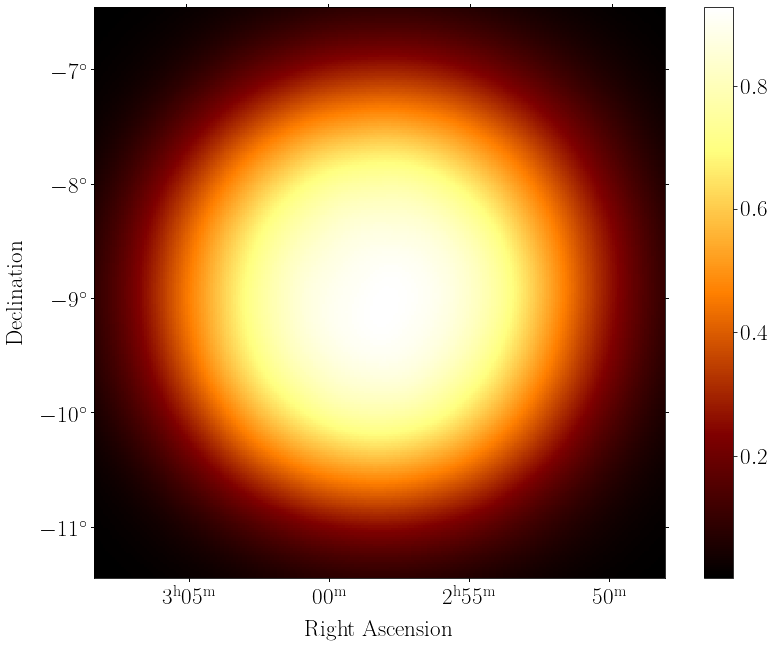

In [18]:
bkg_model = stacked.background_model.evaluate().sum_over_axes().plot(add_cbar= True);
save(fig, '3d_bkg_low_level')

In [19]:
min_energy = np.inf
for obs, ds in zip(observations,datasets):
    thres = energy_axis.edges[:-1][ds.mask_safe.data[:,100,100]][0]
    min_energy = min(min_energy, thres)
    print(obs.obs_id, '{:.4g}'.format(thres))

152900 0.3652 TeV
152901 0.3162 TeV
152902 0.2371 TeV
152903 0.2054 TeV
152904 0.2054 TeV
152905 0.1778 TeV
152906 0.1778 TeV
152907 0.1778 TeV


In [20]:
for ds in datasets:
    ds.models.parameters['tilt'].frozen = False
    

## Define the source model


In [21]:
target_position = SkyCoord(ra=44.544, dec=-8.958, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.0,
    amplitude=1.4e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=0.556 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="grb"
)

In [22]:
for ds in datasets:
    ds.models.append(sky_model)

In [23]:
%%time
fit_joint1 = Fit(datasets)
with np.errstate(divide='ignore', invalid='ignore'):
    result_joint1 = fit_joint1.run(optimize_opts={"print_level":1})

------------------------------------------------------------------
| FCN = 2.843E+05               |     Ncalls=965 (965 total)     |
| EDM = 0.000296 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 8min 15s, sys: 1min 57s, total: 10min 13s
Wall time: 10min 15s


In [24]:
result_joint1.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,norm,9.552e-01,,0.000e+00,nan,False,1.923e-02
1,tilt,-3.057e-01,,nan,nan,False,2.760e-02
2,reference,1.000e+00,TeV,nan,nan,True,0.000e+00
3,index,2.615e+00,,nan,nan,False,8.589e-02
4,amplitude,1.418e-11,cm-2 s-1 TeV-1,nan,nan,False,9.564e-13
5,reference,5.560e-01,TeV,nan,nan,True,0.000e+00
6,lon_0,4.455e+01,deg,nan,nan,False,2.889e-03
7,lat_0,-8.963e+00,deg,-9.000e+01,9.000e+01,False,2.974e-03
8,norm,1.061e+00,,0.000e+00,nan,False,2.265e-02
9,tilt,-2.328e-01,,nan,nan,False,2.712e-02


In [25]:
# We look at the safe mask value as a function of energy at the center of the map
for obs, dataset in zip(observations.ids,datasets):
    indices=np.where(dataset.mask_safe.data[:,50,50])
    print(obs)
    print()
    print( dataset.counts.geom.get_axis_by_name("energy").center[indices], '\n')

152900

[0.39241898 0.45315836 0.52329911 0.60429639 0.69783058 0.80584219
 0.93057204 1.07460783 1.24093776 1.43301257 1.6548171  1.91095297
 2.20673407 2.54829675 2.94272718 3.39820833 3.92418976 4.53158364
 5.23299115 6.0429639  6.97830585 8.05842188 9.30572041] TeV 

152901

[0.33982083 0.39241898 0.45315836 0.52329911 0.60429639 0.69783058
 0.80584219 0.93057204 1.07460783 1.24093776 1.43301257 1.6548171
 1.91095297 2.20673407 2.54829675 2.94272718 3.39820833 3.92418976
 4.53158364 5.23299115 6.0429639  6.97830585 8.05842188 9.30572041] TeV 

152902

[0.25482967 0.29427272 0.33982083 0.39241898 0.45315836 0.52329911
 0.60429639 0.69783058 0.80584219 0.93057204 1.07460783 1.24093776
 1.43301257 1.6548171  1.91095297 2.20673407 2.54829675 2.94272718
 3.39820833 3.92418976 4.53158364 5.23299115 6.0429639  6.97830585
 8.05842188 9.30572041] TeV 

152903

[0.22067341 0.25482967 0.29427272 0.33982083 0.39241898 0.45315836
 0.52329911 0.60429639 0.69783058 0.80584219 0.93057204 1.0746078

152900



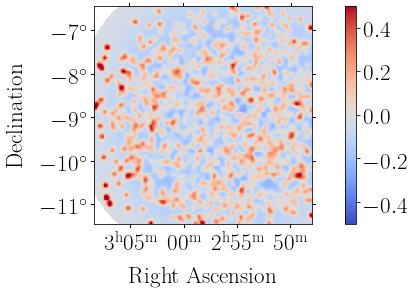

152901



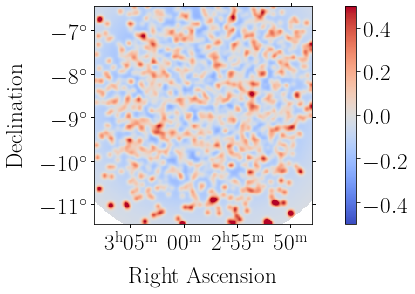

152902



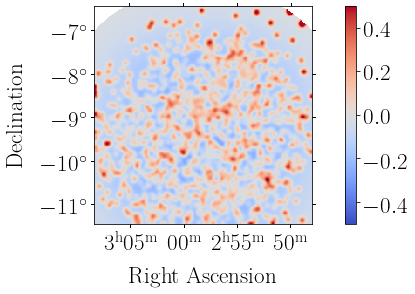

152903



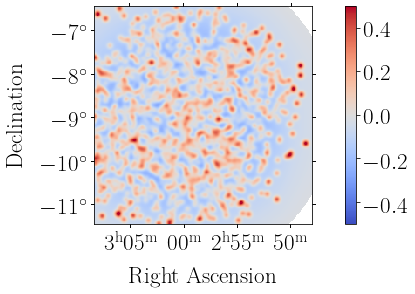

152904



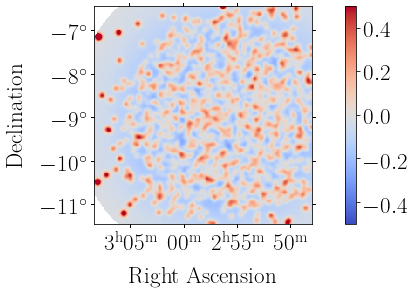

152905



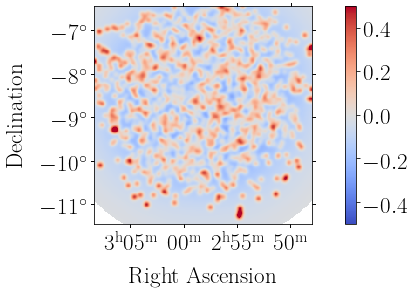

152906



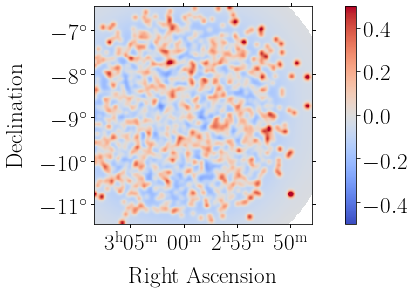

152907



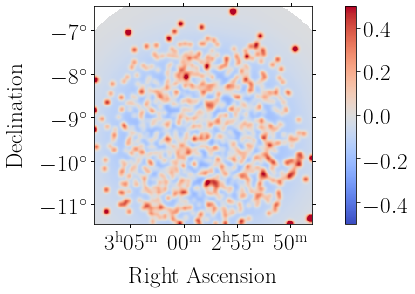

In [26]:
for obs, dataset in zip(observations.ids, datasets):
    print(obs)
    print()
    dataset.plot_residuals("diff/sqrt(model)",smooth_radius="0.05 deg", vmin=-0.5,vmax=0.5)
    
    plt.show()

In [27]:
region = CircleSkyRegion(
    center=SkyCoord("44.544 deg", "-8.958 deg"), radius=0.3 * u.deg
)

region1 = CircleSkyRegion(spatial_model.position, radius=0.3*u.deg)

152900



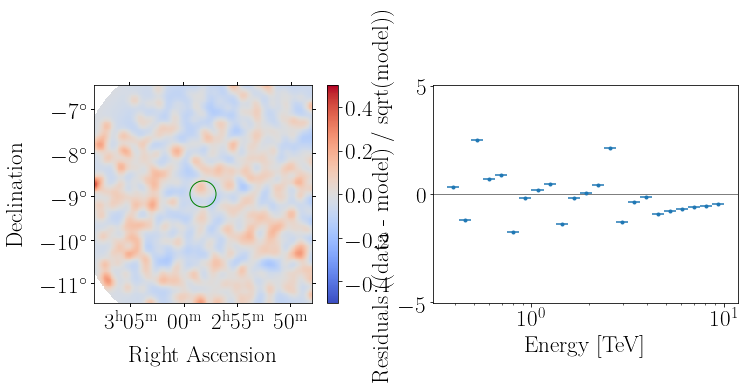

152901



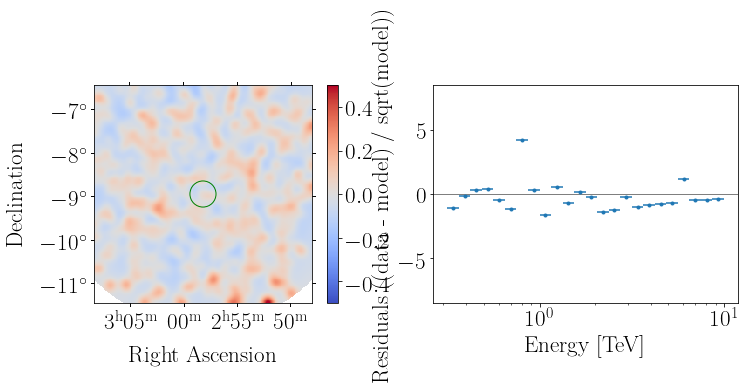

152902



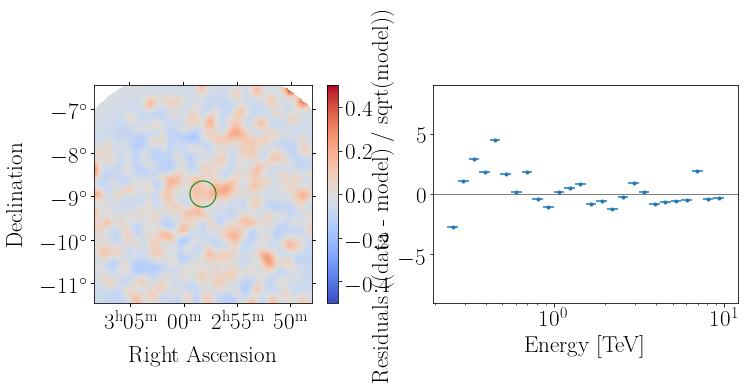

152903



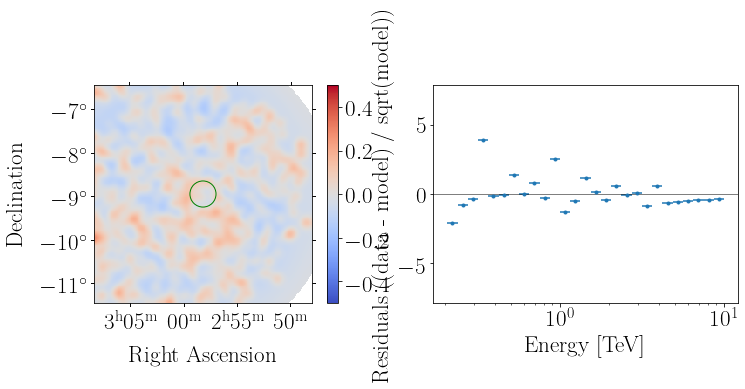

152904



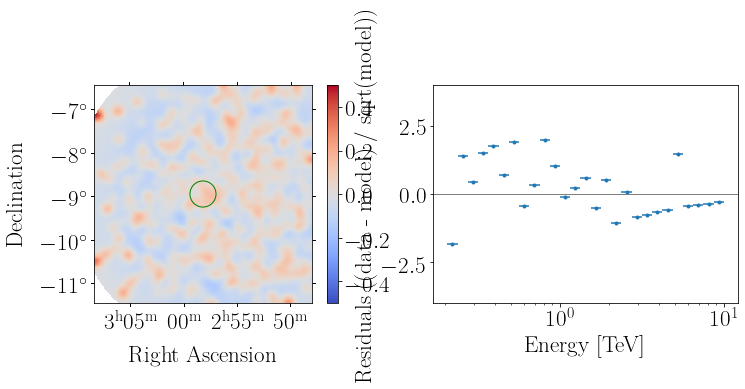

152905



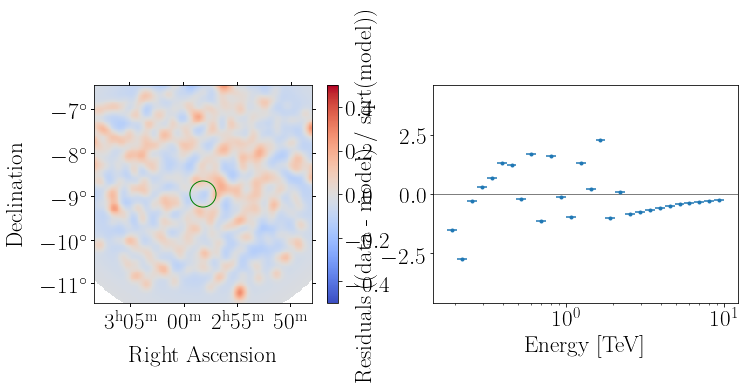

152906



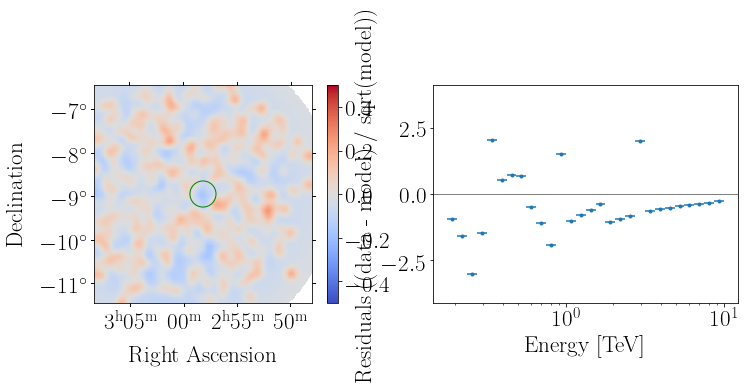

152907



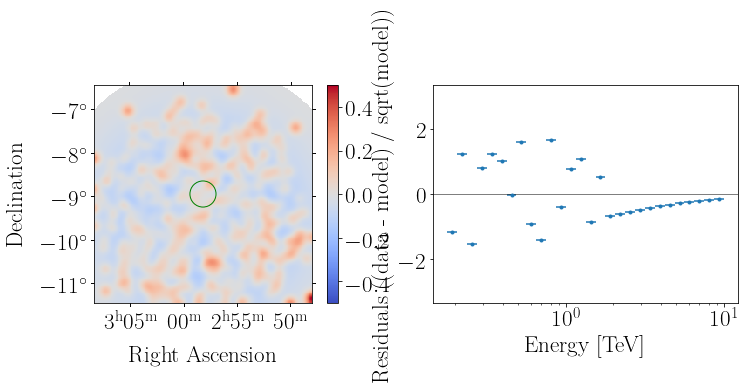

In [28]:
for obs, ds in zip(observations.ids, datasets):
    print (obs)
    print()
    
    ds.plot_residuals(
    region=region, method="diff/sqrt(model)", vmin=-0.5, vmax=0.5
    )
    
    plt.show()

In [29]:
residuals_stacked = Map.from_geom(stacked.counts.geom)
for dataset in datasets:
    residuals = dataset.residuals()
    residuals_stacked.stack(residuals)
residuals_stacked = residuals_stacked.slice_by_idx(dict(energy=slice(3,None)))

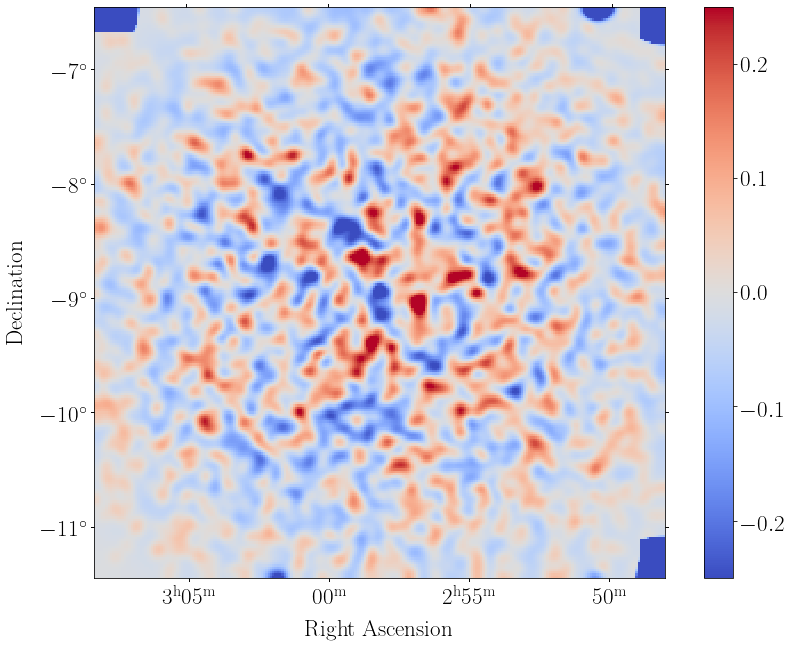

In [30]:
#Residual Map

# (this one likely doesn't take thresholds properly into account)

residuals_stacked.sum_over_axes().smooth(0.05 * u.deg).plot(cmap = 'coolwarm', add_cbar = True, vmin = -0.25, vmax = 0.25);

In [31]:
counts_stacked = Map.from_geom(stacked.counts.geom)
npred_stacked = Map.from_geom(stacked.counts.geom)


for ds in datasets:
    counts_stacked.data[ds.mask_safe.data] += ds.counts.data[ds.mask_safe.data]
    npred_stacked.data[ds.mask_safe.data] += ds.npred().data[ds.mask_safe.data]


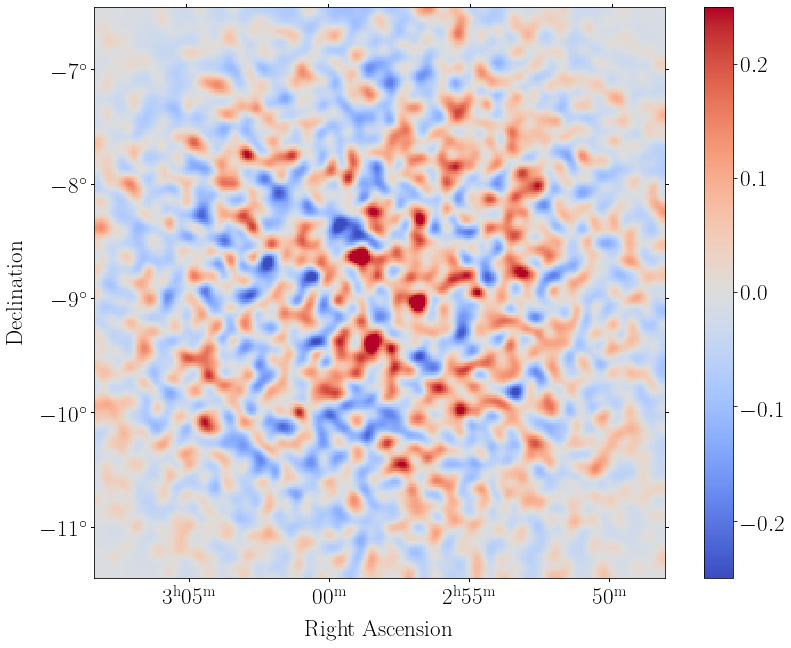

In [32]:
# Residual excess Map
# (This one should properly account for different thresholds)

(counts_stacked - npred_stacked).sum_over_axes().smooth(0.05 * u.deg).plot(add_cbar = True, cmap='coolwarm', vmin = -0.25, vmax = 0.25);

In [33]:
%%time
# compute spectral points
# set binning

ebounds = np.logspace(-0.75, 0.52, 10)
ebounds = ebounds[ebounds.searchsorted(min_energy.value + 1e-4)-1:]

# freeze some parameters

for ds in datasets:
    ds.models.parameters['lon_0'].frozen = True
    ds.models.parameters['lat_0'].frozen = True
    ds.models.parameters['index'].frozen = True
    ds.models.parameters['tilt'].frozen = True

# Estimate points
fpe = FluxPointsEstimator(e_edges = ebounds*u.TeV, source = 'grb', reoptimize=True)

with np.errstate(divide = 'ignore', invalid = 'ignore'):
    flux_point_joint = fpe.run(datasets)

CPU times: user 2h 16min 27s, sys: 26min 10s, total: 2h 42min 37s
Wall time: 9h 49min 52s


In [34]:
flux_point_joint.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [8],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64
0.205,0.178,0.237,1.917e-10,1.144e-11,2.330e-12,8.086e-12,0.513,28349.747,True,0.153,0.163,0.144,0.860,4.720,22.278,0,0.200 .. 5.000,28355.539 .. 28561.990,0 .. 390,9.844e-11,1.649e-10,2.942e-11,3.131e-11,2.756e-11
0.294,0.237,0.365,7.484e-11,9.702e-12,2.806e-12,6.481e-12,0.870,74335.075,True,0.130,0.135,0.126,1.150,10.457,109.358,0,0.200 .. 5.000,74380.486 .. 74676.810,0 .. 607,6.510e-11,8.605e-11,9.766e-12,1.011e-11,9.418e-12
0.422,0.365,0.487,2.921e-11,3.577e-12,1.497e-12,5.194e-12,1.231,49106.211,True,0.181,0.189,0.174,1.622,11.714,137.220,0,0.200 .. 5.000,49173.361 .. 49282.562,537 .. 232,3.595e-11,4.739e-11,5.289e-12,5.514e-12,5.070e-12
0.562,0.487,0.649,1.376e-11,2.247e-12,1.254e-12,4.352e-12,1.455,41444.955,True,0.216,0.225,0.207,1.924,12.227,149.491,0,0.200 .. 5.000,41520.972 .. 41566.028,611 .. 143,2.002e-11,2.647e-11,2.976e-12,3.100e-12,2.853e-12
0.750,0.649,0.866,6.483e-12,1.412e-12,1.051e-12,3.646e-12,1.221,29116.393,True,0.231,0.244,0.218,1.733,9.758,95.224,0,0.200 .. 5.000,29158.891 .. 29223.184,465 .. 91,7.917e-12,1.123e-11,1.495e-12,1.581e-12,1.412e-12
1.075,0.866,1.334,2.530e-12,1.198e-12,1.265e-12,2.922e-12,1.132,28466.918,True,0.214,0.226,0.202,1.609,10.304,106.181,0,0.200 .. 5.000,28509.289 .. 28585.627,462 .. 82,2.865e-12,4.071e-12,5.414e-13,5.719e-13,5.113e-13
1.540,1.334,1.778,9.877e-13,4.417e-13,6.750e-13,2.342e-12,0.704,12242.328,True,0.272,0.302,0.242,1.368,4.660,21.717,0,0.200 .. 5.000,12248.525 .. 12308.028,201 .. 21,6.948e-13,1.351e-12,2.681e-13,2.984e-13,2.391e-13
2.054,1.778,2.371,4.653e-13,2.775e-13,5.655e-13,1.962e-12,0.521,8359.575,True,0.289,0.331,0.249,1.271,2.959,8.755,0,0.200 .. 5.000,8361.452 .. 8411.556,136 .. 11,2.423e-13,5.916e-13,1.346e-13,1.542e-13,1.157e-13


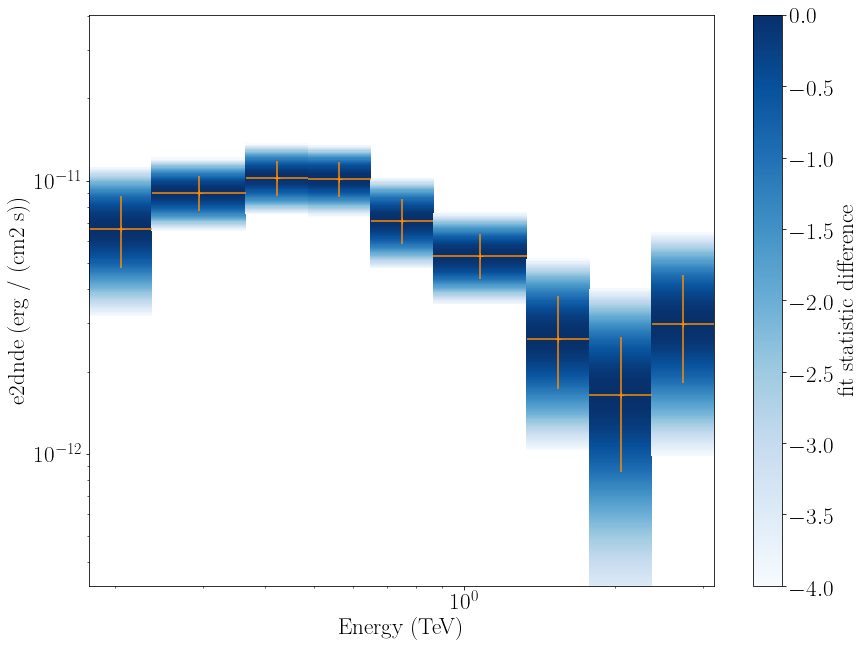

In [35]:
fp = flux_point_joint.table["is_ul"] = flux_point_joint.table["ts"] < 4
ax = flux_point_joint.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
sedp = flux_point_joint.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

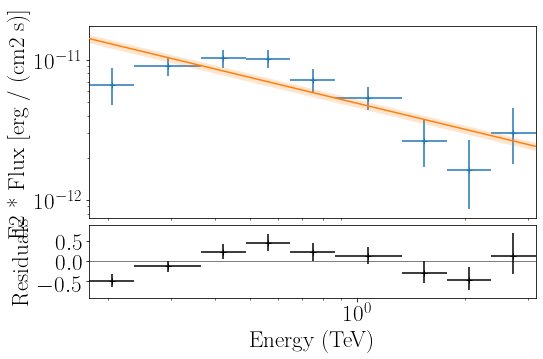

In [36]:
flux_point_dataset = FluxPointsDataset(
    data=flux_point_joint, models= sky_model
)

plt.figure(figsize=(8, 5))
ax_sed, ax_residuals =flux_point_dataset.peek();

In [37]:
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance')
flux    = flux_point_joint.table['dnde'].data
fluxerr = flux_point_joint.table['dnde_err'].data
fluxul  = flux_point_joint.table['dnde_ul'].data
sqrtts  = flux_point_joint.table['sqrt_ts'].data
isul    = sqrtts < 2
for e,f,fl,fh,lim,ul,s in zip(flux_point_joint.table['e_ref'].data, flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e, f, f-fl, f+fh, s))


Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance
    0.205     |   9.844e-11    |   2.942e-11    |   2.263e-10    |      4.72      
    0.294     |    6.51e-11    |   9.766e-12    |    1.4e-10     |     10.46      
    0.422     |   3.595e-11    |   5.289e-12    |   7.718e-11    |     11.71      
    0.562     |   2.002e-11    |   2.976e-12    |   4.301e-11    |     12.23      
    0.750     |   7.917e-12    |   1.495e-12    |   1.733e-11    |      9.76      
    1.075     |   2.865e-12    |   5.414e-13    |   6.272e-12    |     10.30      
    1.540     |   6.948e-13    |   2.681e-13    |   1.658e-12    |      4.66      
    2.054     |   2.423e-13    |   1.346e-13    |   6.193e-13    |      2.96      
    2.738     |   2.481e-13    |   1.113e-13    |   6.075e-13    |      4.70      


In [39]:
flux_point_joint.write('../flux_and_fit_results/night1_3d_flux_points_v17_joint_low_level_final.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts'],
                  overwrite=True)


result_joint1.parameters.to_table().write('../flux_and_fit_results/night1_3d_fit17_jointlow_level_final.csv', overwrite=True)
